# Highway Network实现手写数字识别

**根据论文中的描述，highway network实际上就是一层特殊的网络，与普通神经网络不同，可以理解为在一层神经网络中利用两个激活函数最后输出。**

对于普通的神经网络来说，每层的输出可以表示为(H表示激活函数，W_H表示对应权重，y表示输出)：$$y=H(x,W_H)$$ 
对于Highway来说，每次的输出可以表示为: $$y=H(x,W_H)*T(x, W_T) + x*(1 - T(x, W_T))$$


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
data = tf.keras.datasets.mnist

In [3]:
(x_train, y_train), (x_test, y_test) = data.load_data()

In [4]:
x_train, x_test = x_train / 255.0, x_test / 255.0

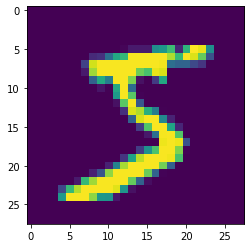

In [5]:
plt.imshow(x_train[0])

In [6]:
(x_train, y_train), (x_test, y_test) = data.load_data()
x_train = x_train.reshape(-1, 784).astype("float32") / 255
x_test = x_test.reshape(-1, 784).astype("float32") / 255
x_train.shape

(60000, 784)

In [9]:
import tensorflow as tf

class HighwayLayer(tf.keras.layers.Layer):
    def __init__(self, units, t_bias):
        super(HighwayLayer, self).__init__()
        self.units = units # 定义输出单元个数
        self.t_bias = t_bias
        self.activationT = tf.nn.relu
        self.activationH = tf.nn.sigmoid

    def build(self, input_shape):
        print(input_shape[-1])
        self.W_H = self.add_weight(name="w_H", 
            shape=(input_shape[-1], self.units), initializer="random_normal", trainable = True
        ) # 添加激活函数H的权重
        self.W_T = self.add_weight(name="w_T",
            shape=(input_shape[-1], self.units), initializer="random_normal", trainable = True
        ) # 添加激活函数T的权重
        self.b_H = self.add_weight(name="b", shape=(self.units,), initializer="random_normal", trainable=True)
        self.b_T = tf.Variable(tf.constant(self.t_bias, shape=self.units), name='bias', trainable=True, dtype=tf.float32)


    def call(self, inputs):
        h = self.activationH(tf.matmul(inputs, self.W_H) + self.b_H)
        t = self.activationT(tf.matmul(inputs, self.W_T) + self.b_T)
        y = tf.add(tf.multiply(h, t) , tf.multiply(inputs, (1 - t)))
        return y

class HighwayNetwork(tf.keras.Model):
    def __init__(self, t_bias = -3.0, num_classes=10, num_of_layers=3): #这里对于激活函数t来说，论文给出的误差值为-1或-3
        super(HighwayNetwork, self).__init__()
        self.projection = tf.keras.layers.Dense(128)
        self.mlplayers = [HighwayLayer(128, t_bias=t_bias) for _ in range(num_of_layers)]
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        X = self.projection(x)
        for layer in self.mlplayers:
            X = layer(X)
        y = self.classifier(X)
        return y

In [10]:
model = HighwayNetwork()

In [11]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy",metrics='accuracy')

In [12]:
model.fit(x_train, y_train,epochs=10)

Epoch 1/10


2022-05-31 22:00:50.480269: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


128
128
128
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3477 - accuracy: 0.9002
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2286 - accuracy: 0.9341
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1732 - accuracy: 0.9497
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1297 - accuracy: 0.9627
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1067 - accuracy: 0.9684
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0924 - accuracy: 0.9718
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0835 - accuracy: 0.9751
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0739 - accuracy: 0.9776
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0634 - accuracy: 0.9809
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.06

In [13]:
model.summary()

Model: "highway_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             multiple                  100480    
                                                                 
 highway_layer_1 (HighwayLay  multiple                 33024     
 er)                                                             
                                                                 
 highway_layer_2 (HighwayLay  multiple                 33024     
 er)                                                             
                                                                 
 highway_layer_3 (HighwayLay  multiple                 33024     
 er)                                                             
                                                                 
 dense_2 (Dense)             multiple                  1290      
                                                 

In [14]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 592us/step - loss: 0.1113 - accuracy: 0.9701


[0.11131760478019714, 0.9700999855995178]